In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np

In [28]:
%config IPCompleter.greedy=True
%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

In [29]:
output_dir = "../output/"

measurements = list()

for direc, sub_direc, files in os.walk(output_dir):
    if files == []:
        continue
    
    for file in files:
        if 'ndr' in file:
            t = pd.read_json(direc + '/' + files[0]).to_dict()
            
            label, flows, repeat = direc.replace(output_dir, '').split('/')

            measurements.append(
                {
                    'cpu_util': t['results']['cpu_util'],
                    'rate_tx_bps': t['results']['rate_tx_bps'],
                    'rate_rx_bps': t['results']['rate_rx_bps'],
                    'rx_pps': t['results']['rx_pps'],
                    'tx_pps': t['results']['tx_pps'],
                    'total_rx_L1': t['results']['total_rx_L1'],
                    'total_tx_L1': t['results']['total_tx_L1'],
                    'total_cores': t['config']['total_cores'],
                    'label': 'label',
                    'flows': int(flows),
                    'repeat': int(repeat)
                }
            )
measurements_df = pd.DataFrame(measurements)

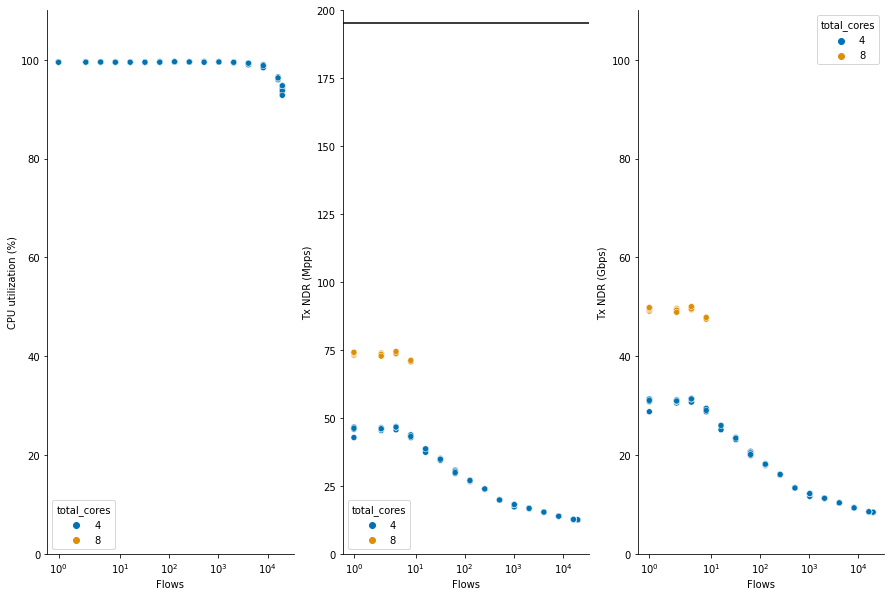

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

ax1.set_xscale('symlog')
ax2.set_xscale('symlog')
ax3.set_xscale('symlog')

sns.scatterplot(
    data = measurements_df,
    x = 'flows',
    y = 'cpu_util',
    hue = 'total_cores',
    # join=False,
    ax = ax1,
    palette = 'colorblind',
)

sns.scatterplot(
    data = measurements_df,
    x = 'flows',
    y = measurements_df['tx_pps']/1000000,
    hue = 'total_cores',
    #join=False,
    ax = ax2,
    palette = 'colorblind',
)

sns.scatterplot(
    data = measurements_df,
    x = 'flows',
    y = measurements_df['total_tx_L1']/1000000000,
    hue = 'total_cores',
    #join=False,
    ax = ax3,
    palette = 'colorblind',
)

ax1.set(
    ylim = [0, 110],
    #xlim = [-1, 20000],
    ylabel = 'CPU utilization (%)',
    xlabel = 'Flows'
       )

ax2.set(
    ylim = [0, 200],
    # xticks = [x for x in np.logspace(0, 14, 15, base=2)],
    ylabel = 'Tx NDR (Mpps)',
    xlabel = 'Flows'

)
ax2.axhline(100000000000/(64*8)/1000000, color = 'black', )


ax3.set(
    ylim = [0, 110],
    # xticks = [x for x in np.logspace(0, 14, 15, base=2)],
    ylabel = 'Tx NDR (Gbps)',
    xlabel = 'Flows'

)

#fig.autofmt_xdate()
sns.despine()